# DRL Course 2023 Домашнее задание 2 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [2]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib import animation

import seaborn as sns
sns.set()

In [3]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

### Задание 1 ###

Пользуясь алгоритмом Кросс-Энтропии для конечного пространства действий обучить агента решать Acrobot-v1 или LunarLander-v2 на выбор. Исследовать гиперпараметры алгоритма и выбрать лучшие.

### Cross-Entropy Method. Case $ S \subset \mathbb{R}^n, \,\, |A| = m $ ###

В код добавленный на семинаре была добавлена возможность использовать шум для начального обучения в случаях неудачной инициализации нейронной сети, однако при выполнении задания не получилось извлечь из шума какой-либо пользы, только более долгое обучение...

In [53]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100), 
            nn.ReLU(), 
            nn.Linear(100, self.action_n)
        )
        
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, betas=(0.9, 0.999))
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        return self.network(_input) 
    
    def get_action(self, state, eps=0):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        noise = torch.FloatTensor([1 / self.action_n for _ in range(self.action_n)])
        action_prob = (1 - eps) * self.softmax(logits) + eps * noise
        action_prob = action_prob.detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        self.optimizer.zero_grad()

        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_actions = torch.LongTensor(elite_actions)
        elite_states = torch.FloatTensor(elite_states[:list(elite_actions.shape)[0]])
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [54]:
def get_trajectory(env, agent, trajectory_len, eps=0, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    
    frames = []
    for i in range(trajectory_len):
        
        action = agent.get_action(state, eps)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            frames.append(env.render(mode="rgb_array"))

        if i != trajectory_len - 1:
            trajectory['states'].append(state)
            
    if visualize:
        save_frames_as_gif(frames, filename=filename)
            
    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [60]:
def train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, noise=False):
    rewards = []
    for episode in range(episode_n):

        eps = 0
        if noise == True:
            eps = 1 / (episode + 1)

        trajectories = [get_trajectory(env, agent, trajectory_len, eps) for _ in range(trajectory_n)]
        
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        rewards.append(mean_total_reward)
        
        print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
        
        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)

    return rewards

### CartPole-v1 ###

In [297]:
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

agent = CEM(state_dim, action_n)

In [298]:
episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

In [ ]:
train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 500.0


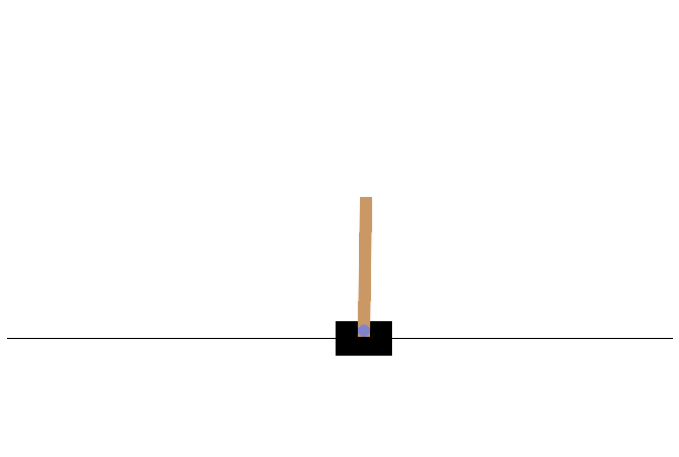

In [59]:
trajectory = get_trajectory(env, agent, trajectory_len, visualize=True, filename='cartpole.gif')
print(f"total reward: {trajectory['total_reward']}")

### Acrobot-v1 ###


Для решения используется модель построенная на семинаре: нет шума, 1 скрытый слой из 100 нейронов, функция активации ReLU

Выбранные гиперпараметры обучения:

```python

episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

```

In [36]:
env = gym.make('Acrobot-v1')
state_dim = 6
action_n = 3

In [37]:
agent = CEM(state_dim, action_n)

In [38]:
episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

In [40]:
rewards_acrobot = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

episode: 0, mean_total_reward = -500.0
episode: 1, mean_total_reward = -500.0
episode: 2, mean_total_reward = -500.0
episode: 3, mean_total_reward = -500.0
episode: 4, mean_total_reward = -500.0
episode: 5, mean_total_reward = -500.0
episode: 6, mean_total_reward = -497.6
episode: 7, mean_total_reward = -487.45
episode: 8, mean_total_reward = -465.35
episode: 9, mean_total_reward = -402.55
episode: 10, mean_total_reward = -307.1
episode: 11, mean_total_reward = -265.0
episode: 12, mean_total_reward = -203.55
episode: 13, mean_total_reward = -190.6
episode: 14, mean_total_reward = -201.15
episode: 15, mean_total_reward = -173.95
episode: 16, mean_total_reward = -178.15
episode: 17, mean_total_reward = -168.6
episode: 18, mean_total_reward = -156.4
episode: 19, mean_total_reward = -147.55
episode: 20, mean_total_reward = -145.55
episode: 21, mean_total_reward = -142.5
episode: 22, mean_total_reward = -149.9
episode: 23, mean_total_reward = -141.2
episode: 24, mean_total_reward = -133.1
e

MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -91.0


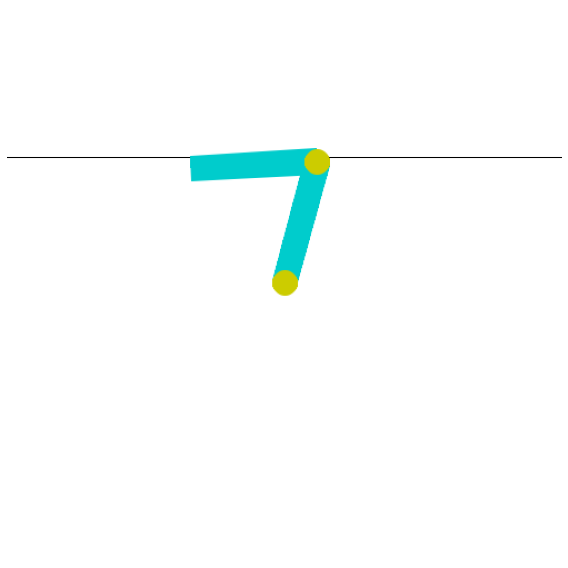

In [42]:
trajectory = get_trajectory(env, agent, trajectory_len, visualize=True, filename="acrobot.gif")
print(f"total reward: {trajectory['total_reward']}")

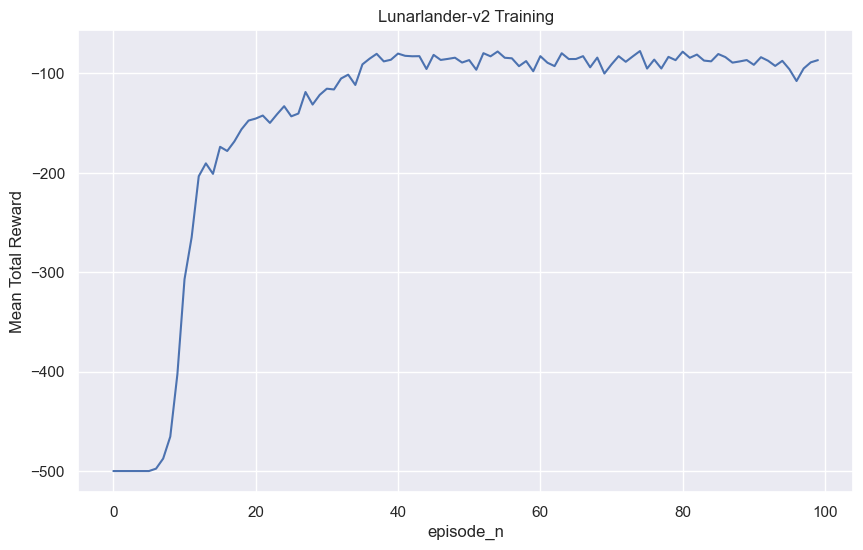

In [52]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Lunarlander-v2 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Mean Total Reward')

plt.plot(rewards_acrobot)
plt.savefig('acrobot_training.png')

### LunarLander-v2  ###


Для решения поставленной задачи было переброваны различные варианты шума, гиперпараметры и архитектуры классифицирующей нейронной сети. Однако я получил наиболее быструю сходимость на параметрах предыдущих заданиях с достаточно большим количеством эпох и везением :).

In [5]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4

In [6]:
agent = CEM(state_dim, action_n)

In [10]:
episode_n = 100
trajectory_n = 20
trajectory_len = 1000
q_param = 0.8

In [11]:
rewards_lunarlander = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode: 0, mean_total_reward = -266.51252882379146
episode: 10, mean_total_reward = -58.59272960141461
episode: 20, mean_total_reward = -13.95507410924338
episode: 30, mean_total_reward = -4.941603384804891
episode: 40, mean_total_reward = 188.61318492106665
episode: 50, mean_total_reward = 129.23953060707038
episode: 60, mean_total_reward = 159.9185555596607
episode: 70, mean_total_reward = 13.992963526234945
episode: 80, mean_total_reward = 17.5514265951811
episode: 90, mean_total_reward = 123.668237130341


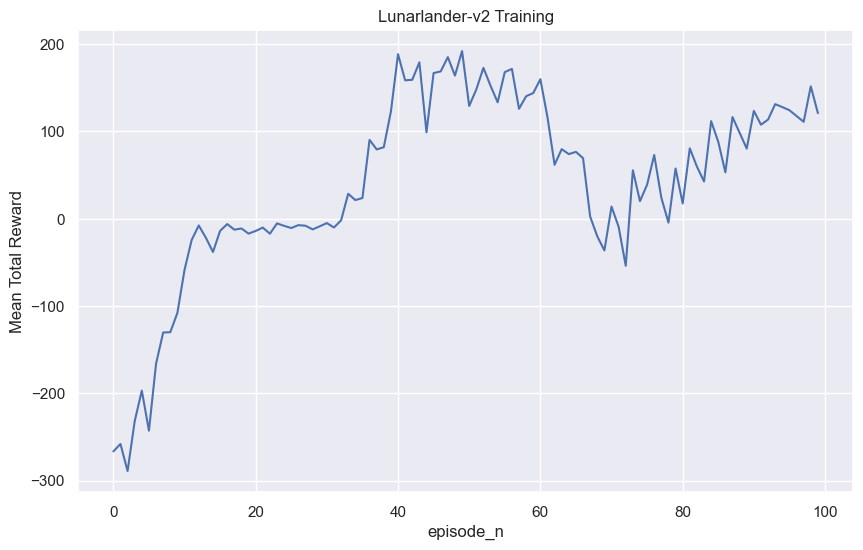

In [50]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Lunarlander-v2 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Mean Total Reward')

plt.plot(rewards_lunarlander)
plt.savefig('lunarlander_training.png')

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 119.32457936972591


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 8.148986953745847


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 24.122137020783953


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 53.95106378852943


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 47.00235610997972


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 97.27682067349568


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 144.4640336651753


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 179.26462247480515


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 131.09097863777353


c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
MovieWriter imagemagick unavailable; using Pillow instead.


total reward: 110.54568594998717


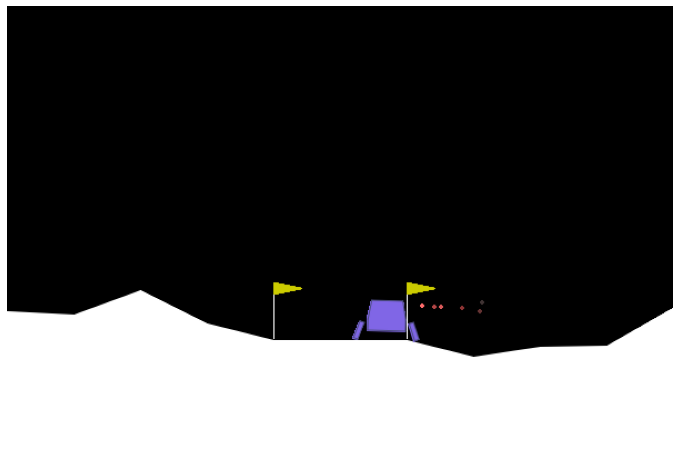

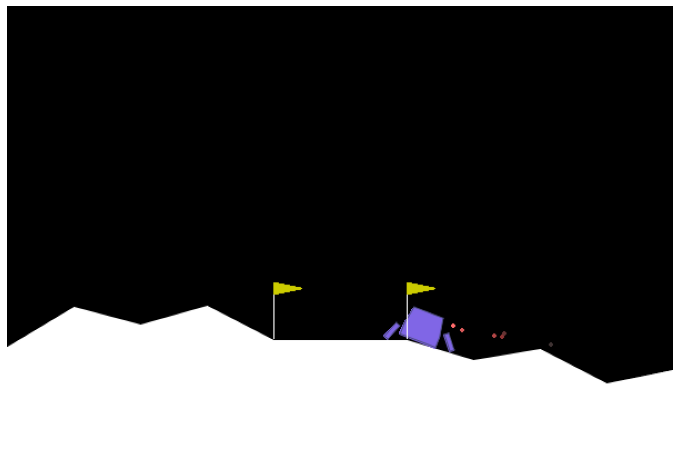

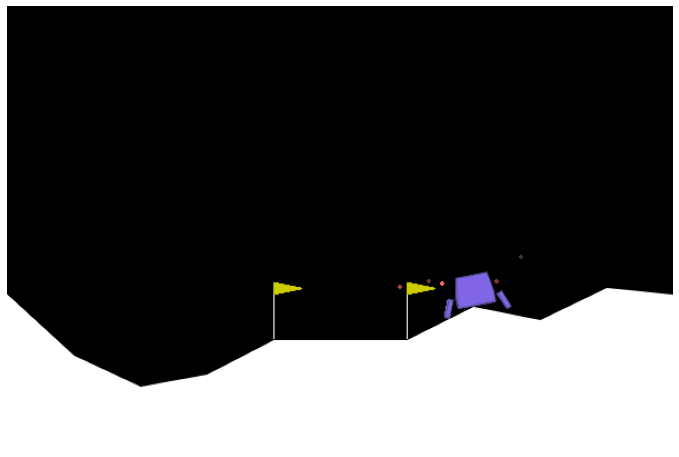

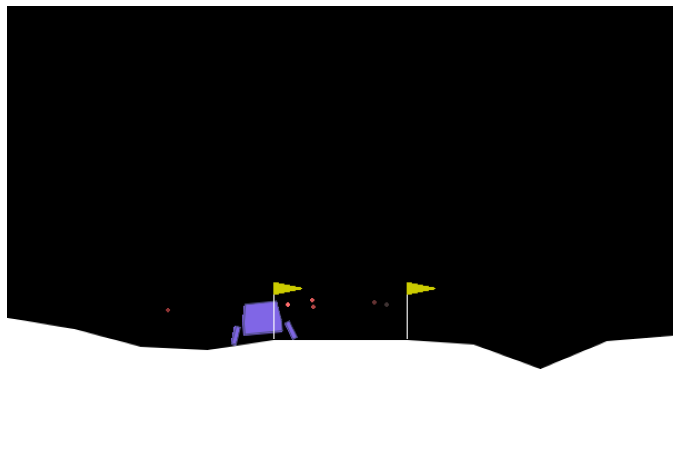

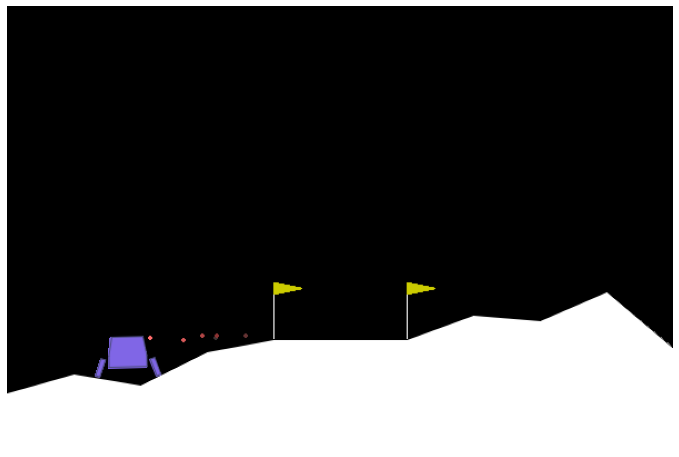

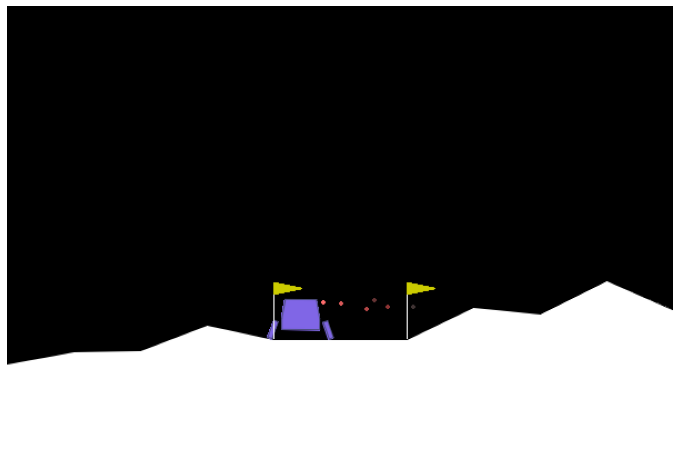

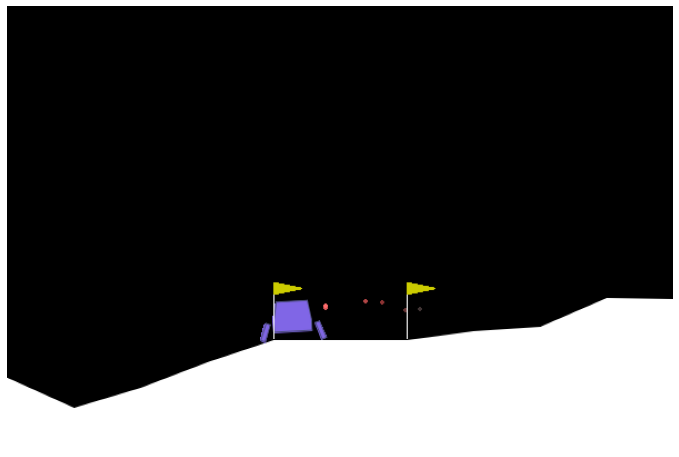

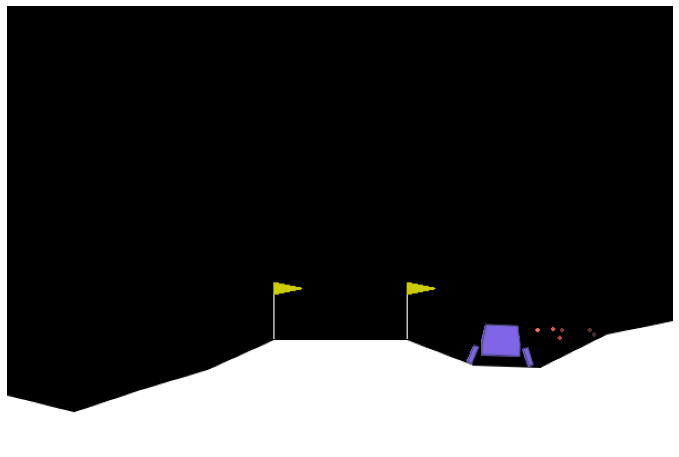

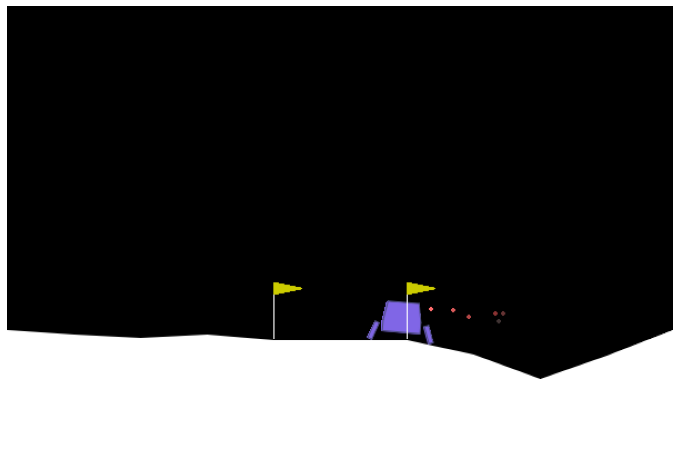

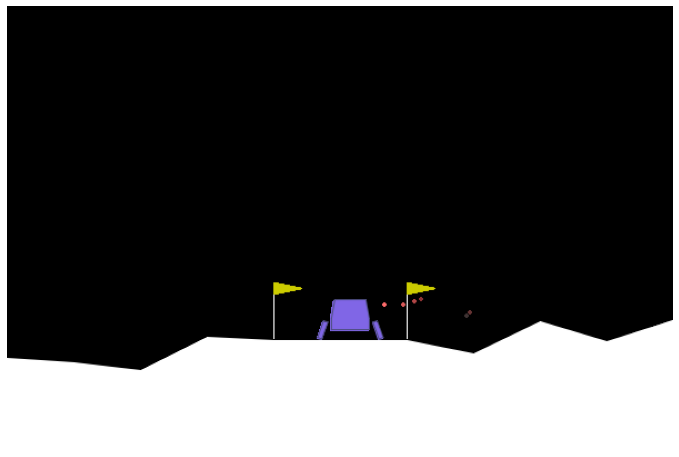

In [13]:
for i in range(10):
    trajectory = get_trajectory(env, agent, trajectory_len=500, visualize=True, filename=f'lunarlander{i}.gif')
    print(f"total reward: {trajectory['total_reward']}")

### Задание 2 ###

Реализовать алгоритм Кросс-Энтропии для непрерывного пространства действий. Обучить агента решать Pendulum-v1 или MountainCarContinuous-v0 на выбор. Исследовать гиперпараметры алгоритма и выбрать лучшие.

### Cross-Entropy Method. Case $ S \subset \mathbb{R}^n, \,\, A \subset \mathbb{R}^m $ ###

Для реализации метода кросс-энтропии в случае непрерывного пространства действий мы переходим от задачи классификации к задаче регрессии. Значит заменяем CrossEntropyLoss на MSELoss, а также избавляемся от софтмакса.

In [44]:
class CEM_continuous(nn.Module):
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.min_action = min_action
        self.max_action = max_action
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100), 
            nn.ReLU(), 
            nn.Linear(100, self.action_dim)
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-1, betas=(0.9, 0.999))
        self.loss = nn.MSELoss()
        
    def forward(self, _input):
        return self.network(_input) 
    
    def get_action(self, state, eps=0):
        state = torch.FloatTensor(state)
        self.min_action = torch.FloatTensor([self.min_action])
        self.max_action = torch.FloatTensor([self.max_action])

        noise = torch.randn(self.action_dim)
        with torch.no_grad():
            action = torch.clamp(self.forward(state) + eps * noise, 
                                 min=self.min_action, max=self.max_action)
        action = action.detach().numpy()

        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.FloatTensor(elite_actions)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

### Pendulum-v1 ###

In [4]:
env = gym.make('Pendulum-v1')
state_dim = 3
action_dim = 1
min_action = -2.0
max_action = 2.0

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [59]:
agent = CEM_continuous(state_dim, action_dim, min_action, max_action)
rewards_pendulum = []

In [61]:
episode_n = 200
trajectory_n = 100
trajectory_len = 200
q_param = 0.6

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-2)

In [62]:
rewards_pendulum_new = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param) 
rewards_pendulum.extend(rewards_pendulum_new)

episode: 0, mean_total_reward = -1399.5094060133183
episode: 1, mean_total_reward = -1359.12381594544
episode: 2, mean_total_reward = -1296.789288441852
episode: 3, mean_total_reward = -1335.1813988367287
episode: 4, mean_total_reward = -1276.6460167924404
episode: 5, mean_total_reward = -1313.44338276731
episode: 6, mean_total_reward = -1330.0833320839474
episode: 7, mean_total_reward = -1333.1290716174244
episode: 8, mean_total_reward = -1328.6284449777688
episode: 9, mean_total_reward = -1361.9882252313976
episode: 10, mean_total_reward = -1377.6561655454548
episode: 11, mean_total_reward = -1377.7529513088487


KeyboardInterrupt: 

MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -1331.897804057391


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -241.09341936877155


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -6.8175349317648894


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -1238.4236393128176


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -9.666237422970175


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -833.2732188233842


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -1376.5786371841384


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -10.52205794966893


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -1023.38695204859


MovieWriter imagemagick unavailable; using Pillow instead.


total reward: -839.2752510204649


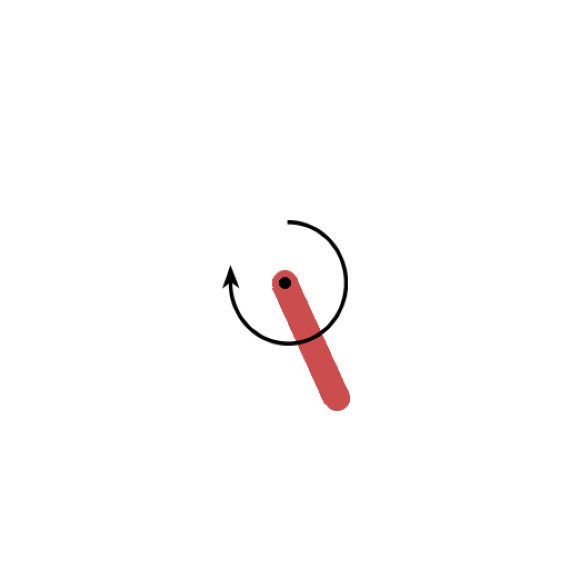

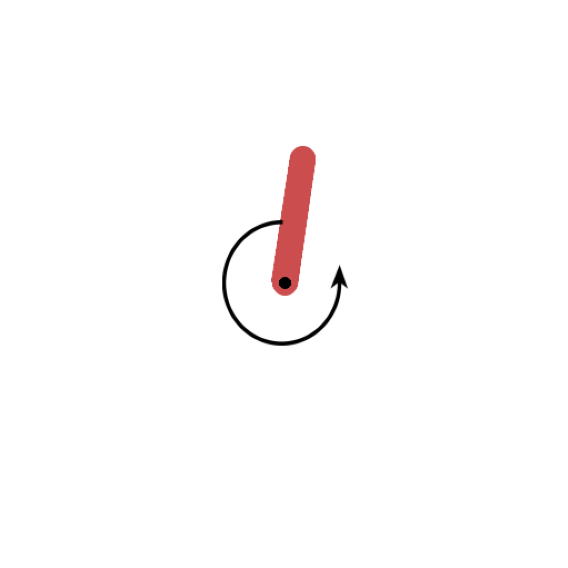

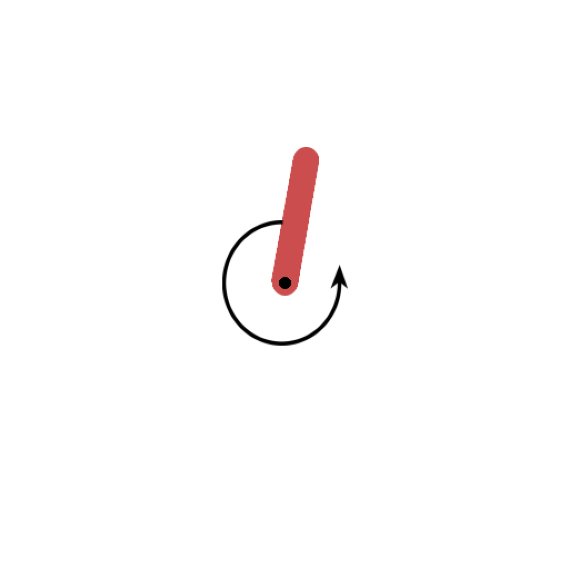

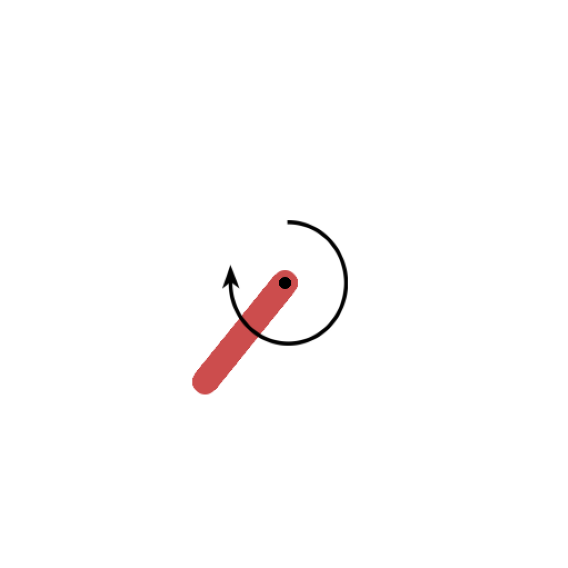

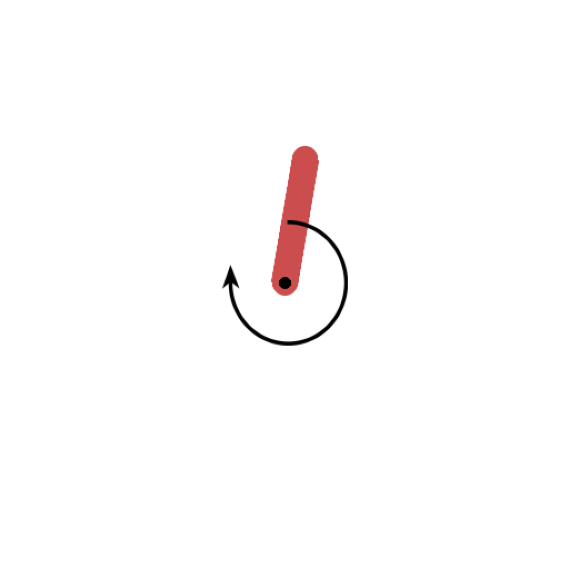

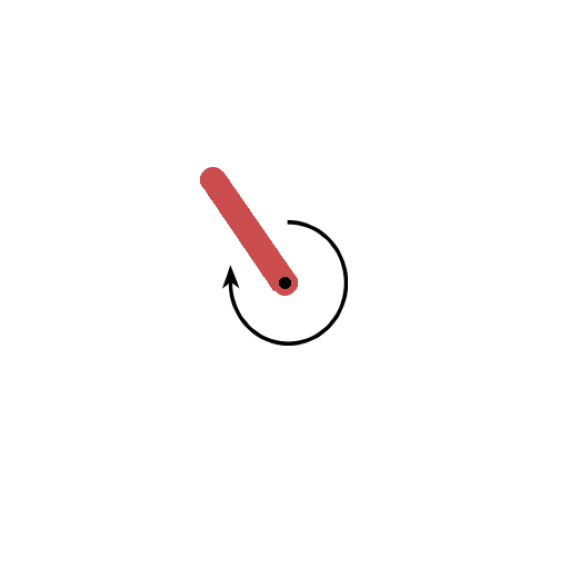

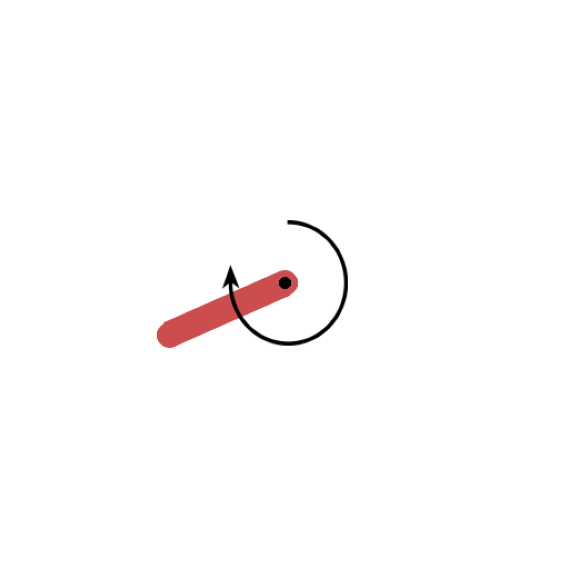

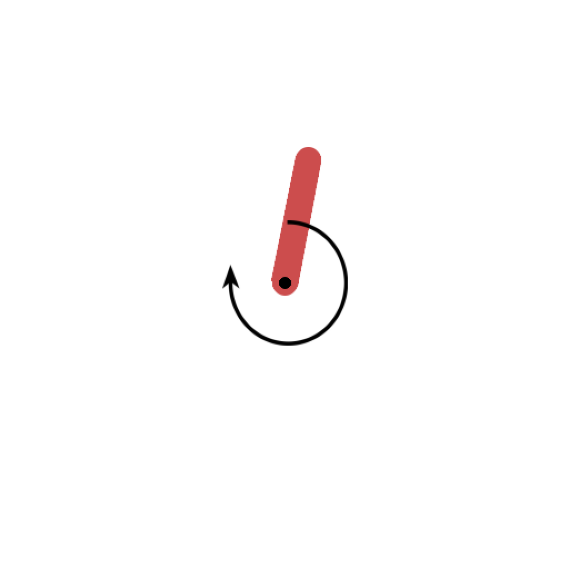

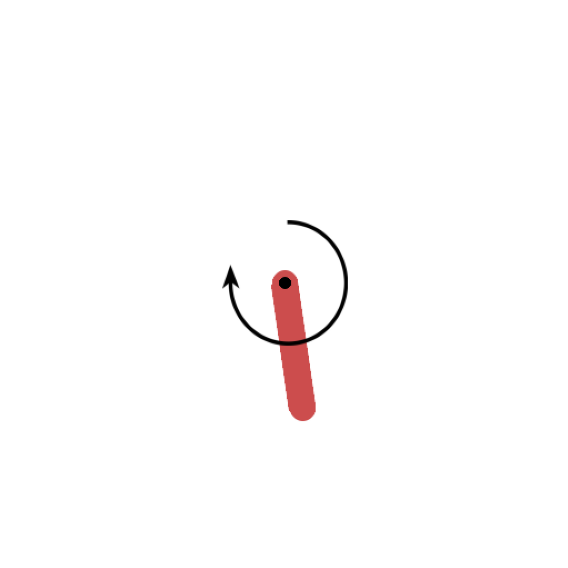

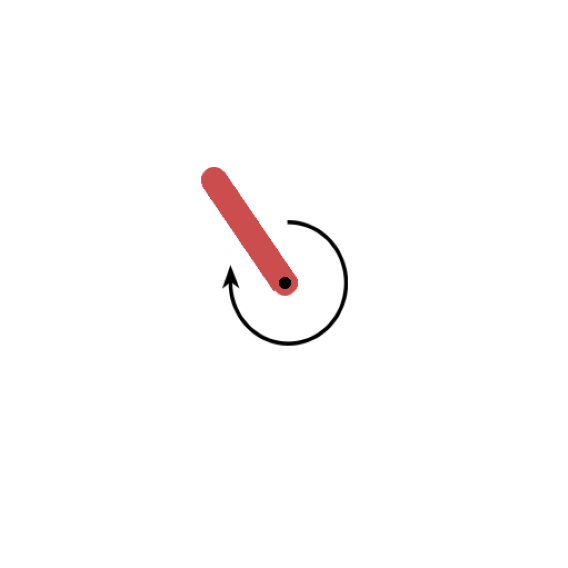

In [288]:
for i in range(10):
    trajectory = get_trajectory(env, agent, trajectory_len, visualize=True, filename=f"pendulum_gifs/pendulum{i}.gif")
    print(f"total reward: {trajectory['total_reward']}")

### MountainCarContinuous-v0 ###

Не пробовал достичь каких-либо результатов.

In [28]:
env = gym.make('MountainCarContinuous-v0')
state_dim = 2
action_dim = 1
min_action = -1.0
max_action = 1.0

agent = CEM_continuous(state_dim, action_dim, min_action, max_action)
episode_n = 10
trajectory_n = 20
trajectory_len = 200
q_param = 0.6

In [29]:
train(env, agent, episode_n, trajectory_n, trajectory_len, q_param) 

ValueError: expected 2D or 3D input (got 1D input)

MovieWriter imagemagick unavailable; using Pillow instead.


{'states': [array([-0.59669447,  0.        ], dtype=float32),
  array([-0.5960758 ,  0.00061868], dtype=float32),
  array([-0.5948434 ,  0.00123236], dtype=float32),
  array([-0.593007  ,  0.00183636], dtype=float32),
  array([-0.59058094,  0.00242608], dtype=float32),
  array([-0.58758396,  0.00299701], dtype=float32),
  array([-0.5840392 ,  0.00354478], dtype=float32),
  array([-0.57997406,  0.00406516], dtype=float32),
  array([-0.5754199 ,  0.00455412], dtype=float32),
  array([-0.57041204,  0.00500787], dtype=float32),
  array([-0.5649892 ,  0.00542284], dtype=float32),
  array([-0.55919343,  0.00579577], dtype=float32),
  array([-0.5530697 ,  0.00612372], dtype=float32),
  array([-0.5466656 ,  0.00640408], dtype=float32),
  array([-0.54003096,  0.00663464], dtype=float32),
  array([-0.53321743,  0.00681355], dtype=float32),
  array([-0.526278  ,  0.00693941], dtype=float32),
  array([-0.5192668 ,  0.00701123], dtype=float32),
  array([-0.5122383 ,  0.00702847], dtype=float32),
  

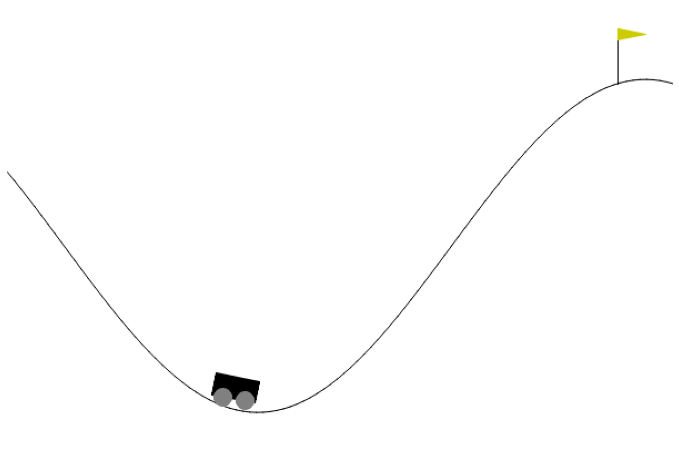

In [6]:
get_trajectory(env, agent, trajectory_len, visualize=True, filename="mountaincar.gif")